In [ ]:
# My data set is from kaggle : https://www.kaggle.com/cjgdev/formula-1-race-data-19502017 The data set is about 
# Formula 1 races from 1950 to 2017. Data set was split into multiple csv files as it was normalized. I combined the 
# data using their primary key to get the data that I wanted. I removed some feature from the data as those features 
# referred to the data collected after the completion of the race. I am trying to predict if the driver will be in 
# the top three positions or not before the race begins. This being a classification problem the metric I am using to
# compare models is precision and ROC AUC where I am focusing more on precision as I want to be sure of the positive
# outcome if ever any of my model gets used for betting purposes. I am using the data from 1950 to 2016 as training 
# data and 2017 as test data. The features I am using are the grid position, number(couldn't find description on 
# that), circuit latitude and longitude, qualifying time and nationality. In F1, three qualifier races are conducted.
# I have taken the fastest time from the three as a feature. The first qualifying lap is compulsory but the other 
# two are not and there can be reasons for driver to take or not to take qualifying 2 or 3 so I took that fastest time 
# out of the three.If you do not race in the 1st qualifier you can't take part in the main race and some qualifying 
# lap timings were missing so I took a very large value for the missing data. 
# number of rows : 23771
# number of columns : 4

Populating the interactive namespace from numpy and matplotlib


In [54]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
import numpy as np

%matplotlib inline  
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [55]:
# Loading the csv file and print the columns description.
main = pd.read_csv('final.csv').dropna().drop(['Unnamed: 0','resultId','raceId','driverId','constructorId','positionOrder','nationality','circuitId'], axis= 1)\
    
model_name = []
model_acc = []
model_prec =[] 
model_auc =[]
main.describe()

,number,grid,year,lat,lng,American,American-Italian,Argentine,Argentine-Italian,Australian,...,Rhodesian,Russian,South African,Spanish,Swedish,Swiss,Thai,Uruguayan,Venezuelan,qualifying_time
count,23771.000000,23771.000000,23771.000000,23771.000000,23771.000000,23771.000000,23771.000000,23771.000000,23771.000000,23771.000000,...,23771.000000,23771.000000,23771.000000,23771.000000,23771.000000,23771.000000,23771.000000,23771.000000,23771.000000,23771.000000
mean,16.965462,11.273148,1987.681545,34.090111,4.655182,0.053763,0.000084,0.015649,0.000084,0.030205,...,0.000757,0.005553,0.008834,0.027513,0.020571,0.020866,0.000799,0.000294,0.005048,916483.219048
std,13.644798,7.345181,17.969866,25.689665,57.126599,0.225554,0.009172,0.124117,0.009172,0.171154,...,0.027508,0.074313,0.093577,0.163575,0.141947,0.142938,0.028261,0.017158,0.070872,262995.270852
min,0.000000,0.000000,1950.000000,-37.849700,-118.189000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,64300.000000
25%,7.000000,5.000000,1975.000000,34.843100,-2.940560,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1000000.000000
50%,15.000000,11.000000,1989.000000,44.343900,5.971390,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1000000.000000
75%,23.000000,17.000000,2003.000000,49.327800,11.716700,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1000000.000000
max,208.000000,34.000000,2017.000000,57.265300,144.968000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1000000.000000


In [56]:
# Splitting the data into training and test data. The train data is from 1950 to 2016 and 2017 data as test data.
test = main[main['year'] == 2017]
train = main[main['year'] != 2017]

Xtrain = train.drop(['year','podium'], axis=1)
Xtest = test.drop(['year','podium'], axis=1)

Ytest = test['podium']
Ytrain = train['podium']


In [57]:
# classifying using knn 
# knn with 9 neighbours had the best performance out of all the setting I tried.  
knn = KNeighborsClassifier(9)
knn.fit(Xtrain, Ytrain)
knn_preds = knn.predict(Xtest)

conf = confusion_matrix(Ytest, knn_preds, labels=knn.classes_)
print('Confusion matrix:\n')
print(knn.classes_)
print(conf)
acc = accuracy_score(Ytest, knn_preds)
print('\nThe accuracy is: ', acc)
print()
precision = precision_recall_fscore_support(Ytest, knn_preds, average='binary')
print('precision ',precision[0])
p_pred = [p[True] for p in knn_preds] # probability of the positive class
auc = roc_auc_score(Ytest, p_pred)
print('area under curve',auc)

model_name.append('knn 9')
model_acc.append(acc)
model_prec.append(precision[0])
model_auc.append(auc)

Confusion matrix:

[False  True]
[[321  19]
 [ 50  10]]

The accuracy is:  0.8275

precision  0.3448275862068966
are under curve 0.5553921568627451


In [58]:
# classification using LDA
# as KNN performance was not that great Trying LDA
lda = LinearDiscriminantAnalysis()
lda.fit(Xtrain, Ytrain)
lda_preds = lda.predict(Xtest)

conf = confusion_matrix(Ytest, lda_preds, labels=lda.classes_)
print('Confusion matrix:\n')
print(lda.classes_)
print(conf)
acc = accuracy_score(Ytest, lda_preds)
print('\nThe accuracy is: ', acc)

precision = precision_recall_fscore_support(Ytest, lda_preds, average='binary')
print('precision ',precision[0])
auc = roc_auc_score(Ytest, lda_preds)
print('area under curve',auc)

model_name.append('LDA')
model_acc.append(acc)
model_prec.append(precision[0])
model_auc.append(auc)

# Got a better overall performance out of LDA as compared to KNN

Confusion matrix:

[False  True]
[[333   7]
 [ 45  15]]

The accuracy is:  0.87
precision  0.6818181818181818
area under curve 0.6147058823529411


C:\ProgramData\Anaconda3\envs\untitled\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [59]:
# Baseline accuracy
# compared the test data with data where all the entries were false to get a baseline accuracy.  
baseline_preds = []*400
baseline_preds[0:400] = [False]*400

conf = confusion_matrix(Ytest, baseline_preds, labels=lda.classes_)
print('Confusion matrix:\n')
print(lda.classes_)
print(conf)
acc = accuracy_score(Ytest, baseline_preds)
print('\nThe accuracy is: ', acc)

precision = precision_recall_fscore_support(Ytest, baseline_preds, average='binary')
print('precision ',precision[0])
auc = roc_auc_score(Ytest, baseline_preds)
print('area under curve ',auc)

model_name.append('baseline accuracy')
model_acc.append(acc)
model_prec.append(precision[0])
model_auc.append(auc)

Confusion matrix:

[False  True]
[[340   0]
 [ 60   0]]

The accuracy is:  0.85
precision  0.0
area under curve  0.5


C:\ProgramData\Anaconda3\envs\untitled\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


number of features before selecting important features  46
number of features after selecting important features 5


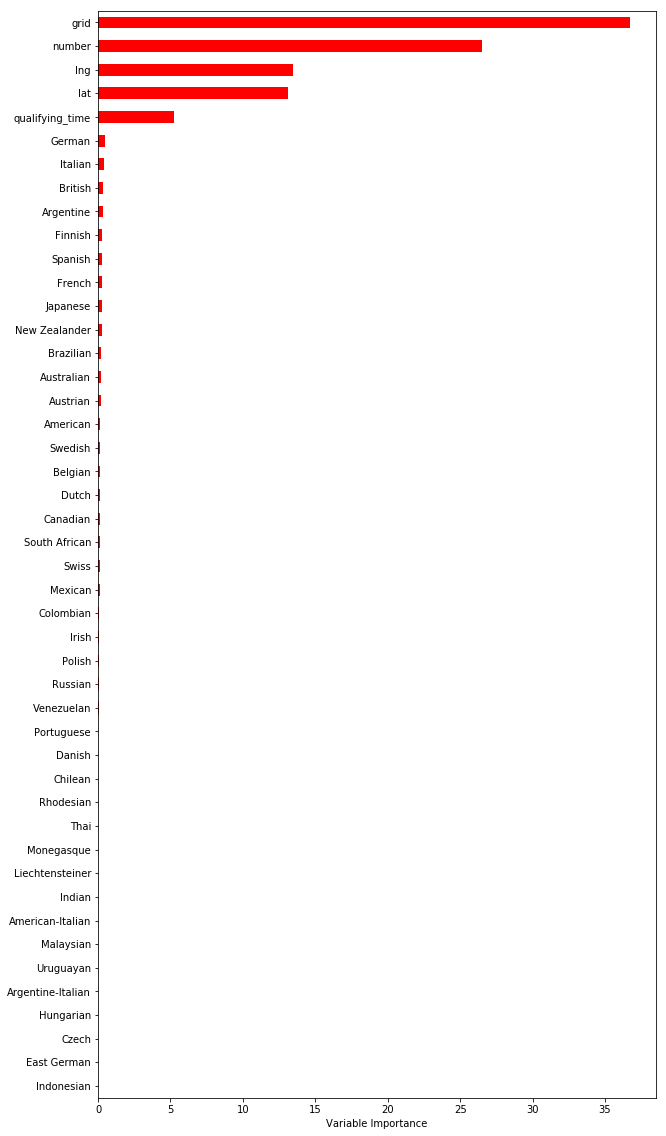

In [60]:
# Getting important features out all the features.
# will using the important features from this tree to train models.
clf = ExtraTreesClassifier()
clf = clf.fit(Xtrain, Ytrain)
model = SelectFromModel(clf, prefit=True)
Xtrain_new = model.transform(Xtrain)
Xtest_new = model.transform(Xtest)

Importance = pd.DataFrame({'Importance':clf.feature_importances_*100}, index=Xtrain.columns)
pylab.rcParams['figure.figsize'] = (10, 20)
Importance.sort_values(by='Importance', axis=0, ascending=True).plot(kind='barh', color='r')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None



print('number of features before selecting important features ', len(Xtrain.columns))
print('number of features after selecting important features', Xtrain_new.shape[1])

In [61]:
# Knn using subset of features 
# using the important features extracted to train KNN, 6 neighbours was giving me the best performance.
knn = KNeighborsClassifier(6)
knn.fit(Xtrain_new, Ytrain)
knn_preds = knn.predict(Xtest_new)

conf = confusion_matrix(Ytest, knn_preds, labels=knn.classes_)
print('Confusion matrix:\n')
print(knn.classes_)
print(conf)
acc = accuracy_score(Ytest, knn_preds)
print('\nThe accuracy is: ', acc)
print()
precision = precision_recall_fscore_support(Ytest, knn_preds, average='binary')
print('precision ', precision[0])
p_pred = [p[True] for p in knn_preds] # probability of the positive class
auc = roc_auc_score(Ytest, p_pred)
print('are under curve',auc)

model_name.append('knn 6, imp features')
model_acc.append(acc)
model_prec.append(precision[0])
model_auc.append(auc)

# got a better performance than the previous KNN model but the improvement was not tht great


Confusion matrix:

[False  True]
[[328  12]
 [ 51   9]]

The accuracy is:  0.8425

precision  0.42857142857142855
are under curve 0.5573529411764706


In [62]:
# LDA using subset of features 
# using the important features extracted to train the model.
lda = LinearDiscriminantAnalysis()
lda.fit(Xtrain_new, Ytrain)
lda_preds = lda.predict(Xtest_new)

conf = confusion_matrix(Ytest, lda_preds, labels=lda.classes_)
print('Confusion matrix:\n')
print(lda.classes_)
print(conf)
acc = accuracy_score(Ytest, lda_preds)
print('\nThe accuracy is: ', acc)

precision = precision_recall_fscore_support(Ytest, lda_preds, average='binary')
print('precision ',precision[0])
auc = roc_auc_score(Ytest, lda_preds)
print('area under curve',auc)

model_name.append('lda, imp features')
model_acc.append(acc)
model_prec.append(precision[0])
model_auc.append(auc)

# The performance increased by a lot from the previous LDA model.

Confusion matrix:

[False  True]
[[336   4]
 [ 49  11]]

The accuracy is:  0.8675
precision  0.7333333333333333
area under curve 0.5857843137254902


In [63]:
# random forests classifier with default settings

rfc = RandomForestClassifier()
rfc.fit(Xtrain,Ytrain)
rfc_preds = rfc.predict(Xtest)

conf = confusion_matrix(Ytest, rfc_preds, labels=rfc.classes_)
print('Confusion matrix:\n')
print(rfc.classes_)
print(conf)
acc = accuracy_score(Ytest, rfc_preds)
print('\nThe accuracy is: ', acc)

precision = precision_recall_fscore_support(Ytest, rfc_preds, average='binary')
print('precision ',precision[0])
auc = roc_auc_score(Ytest, rfc_preds)
print('area under curve',auc)

model_name.append('RFC default')
model_acc.append(acc)
model_prec.append(precision[0])
model_auc.append(auc)

# better performance than KNN bit not as good as LDA


Confusion matrix:

[False  True]
[[325  15]
 [ 39  21]]

The accuracy is:  0.865
precision  0.5833333333333334
area under curve 0.6529411764705882


In [64]:
# gradient boosted trees with default settings

gbc = GradientBoostingClassifier()
gbc.fit(Xtrain,Ytrain)
gbc_preds = gbc.predict(Xtest)

conf = confusion_matrix(Ytest, gbc_preds, labels=gbc.classes_)
print('Confusion matrix:\n')
print(gbc.classes_)
print(conf)
acc = accuracy_score(Ytest, gbc_preds)
print('\nThe accuracy is: ', acc)

precision = precision_recall_fscore_support(Ytest, gbc_preds, average='binary')
print('precision ',precision[0])
auc = roc_auc_score(Ytest, gbc_preds)
print('area under curve',auc)

model_name.append('GBC default')
model_acc.append(acc)
model_prec.append(precision[0])
model_auc.append(auc)

# with default setting great performance. Better than KNN and random forests. With some changes in the options 
# performance could be increased. 

Confusion matrix:

[False  True]
[[327  13]
 [ 29  31]]

The accuracy is:  0.895
precision  0.7045454545454546
area under curve 0.7392156862745098


In [65]:
# gradient boosted trees with options 
gbc = GradientBoostingClassifier( n_estimators=500, learning_rate=0.01, max_depth=4, random_state=1)
gbc.fit(Xtrain,Ytrain)
gbc_preds = gbc.predict(Xtest)

conf = confusion_matrix(Ytest, gbc_preds, labels=gbc.classes_)
print('Confusion matrix:\n')
print(gbc.classes_)
print(conf)
acc = accuracy_score(Ytest, gbc_preds)
print('\nThe accuracy is: ', acc)

precision = precision_recall_fscore_support(Ytest, gbc_preds, average='binary')
print('precision ',precision[0])
auc = roc_auc_score(Ytest, gbc_preds)
print('area under curve',auc)

model_name.append('GBC depth 4')
model_acc.append(acc)
model_prec.append(precision[0])
model_auc.append(auc)

# changing the default options the performance increased dramatically. 
# the best performing model out of the models tried 

Confusion matrix:

[False  True]
[[330  10]
 [ 28  32]]

The accuracy is:  0.905
precision  0.7619047619047619
area under curve 0.7519607843137254


In [66]:
# gradient boosted trees with options
gbc = GradientBoostingClassifier( n_estimators=500, learning_rate=0.01, max_depth=5, random_state=1)
gbc.fit(Xtrain,Ytrain)
gbc_preds = gbc.predict(Xtest)

conf = confusion_matrix(Ytest, gbc_preds, labels=gbc.classes_)
print('Confusion matrix:\n')
print(gbc.classes_)
print(conf)
acc = accuracy_score(Ytest, gbc_preds)
print('\nThe accuracy is: ', acc)

precision = precision_recall_fscore_support(Ytest, gbc_preds, average='binary')
print('precision ',precision[0])
auc = roc_auc_score(Ytest, gbc_preds)
print('area under curve',auc)

model_name.append('GBC depth 5')
model_acc.append(acc)
model_prec.append(precision[0])
model_auc.append(auc)

# ROC AUC increased but accuracy and precision didn't increase. 
# performing a little bit better 

Confusion matrix:

[False  True]
[[329  11]
 [ 25  35]]

The accuracy is:  0.91
precision  0.7608695652173914
area under curve 0.7754901960784314


In [47]:
# perceptron using all features
# takes a long time to train

perc = Perceptron(penalty='l1', random_state=2, max_iter=100000, shuffle=True)
perc.fit(Xtrain, Ytrain)
perc_preds = perc.predict(Xtest)

conf = confusion_matrix(Ytest, perc_preds, labels=perc.classes_)
print('Confusion matrix:\n')
print(perc.classes_)
print(conf)
acc = accuracy_score(Ytest, perc_preds)
print('\nThe accuracy is: ', acc)

precision = precision_recall_fscore_support(Ytest, perc_preds, average='binary')
print('precision ',precision[0])
auc = roc_auc_score(Ytest, perc_preds)
print('area under curve',auc)

model_name.append('perceptron')
model_acc.append(acc)
model_prec.append(precision[0])
model_auc.append(auc)

# output
#Confusion matrix:

#[False  True]
#[[338   2]
# [ 47  13]]

#The accuracy is:  0.8775
#precision  0.8666666666666667
#area under curve 0.6053921568627452


# got the highest precision but ROC AUC is low and accuracy as good when compared to other models.

Confusion matrix:

[False  True]
[[338   2]
 [ 47  13]]

The accuracy is:  0.8775
precision  0.8666666666666667
area under curve 0.6053921568627452


In [48]:
# neural network
# quite bad performance 

nn = MLPClassifier(hidden_layer_sizes=(30,10,5,2), max_iter=1000000, activation='relu', random_state=1)
nn.fit(Xtrain,Ytrain)
nn_preds = nn.predict(Xtest)

conf = confusion_matrix(Ytest, nn_preds, labels=nn.classes_)
print('Confusion matrix:\n')
print(nn.classes_)
print(conf)
acc = accuracy_score(Ytest, nn_preds)
print('\nThe accuracy is: ', acc)

precision = precision_recall_fscore_support(Ytest, nn_preds, average='binary')
print('precision ',precision[0])
auc = roc_auc_score(Ytest, nn_preds)
print('area under curve',auc)

model_name.append('MLP')
model_acc.append(acc)
model_prec.append(precision[0])
model_auc.append(auc)

# this had the bes ROC AUC but bad accuracy and precision. worst than KNN.
# interesting thing was that it had teh highest ROC AUC.


Confusion matrix:

[False  True]
[[202 138]
 [  1  59]]

The accuracy is:  0.6525
precision  0.29949238578680204
area under curve 0.7887254901960785


In [49]:
# using random forests with options

rfc = RandomForestClassifier(random_state= 1 , max_depth=13)
rfc.fit(Xtrain,Ytrain)
rfc_preds = rfc.predict(Xtest)

conf = confusion_matrix(Ytest, rfc_preds, labels=rfc.classes_)
print('Confusion matrix:\n')
print(rfc.classes_)
print(conf)
acc = accuracy_score(Ytest, rfc_preds)
print('\nThe accuracy is: ', acc)

precision = precision_recall_fscore_support(Ytest, rfc_preds, average='binary')
print('precision ',precision[0])
auc = roc_auc_score(Ytest, rfc_preds)
print('area under curve',auc)


model_name.append('RFC depth 13')
model_acc.append(acc)
model_prec.append(precision[0])
model_auc.append(auc)

# changing the default options and got a better performance when compared to the previous 
# RFC. Precision increased but ROC AUC and accuracy didn't increase buy a lot.

Confusion matrix:

[False  True]
[[331   9]
 [ 36  24]]

The accuracy is:  0.8875
precision  0.7272727272727273
area under curve 0.6867647058823528


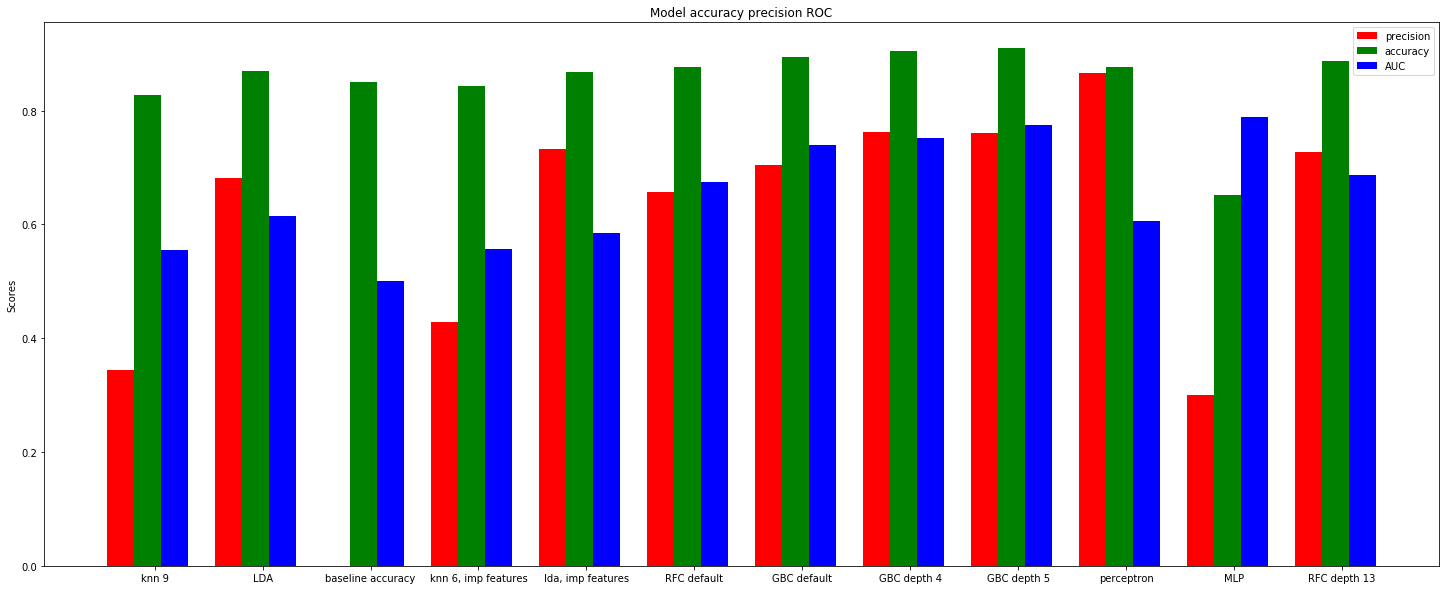

In [ ]:
ind = np.arange(len(model_name))
width = 0.25
fig, ax = plt.subplots(figsize=(25,10))

rects1 = ax.bar(ind - width, model_prec, width, color='r')
rects2 = ax.bar(ind, model_acc, width, color='g')
rects3 = ax.bar(ind + width, model_auc, width, color='b')
ax.set_ylabel('Scores')
ax.set_title('Model accuracy precision ROC')
ax.set_xticks(ind + width  / 4)
ax.set_xticklabels(model_name)
ax.legend((rects1[0], rects2[0],rects3[0]), ('precision', 'accuracy','AUC'))
plt.show()




In [ ]:
# Gradient boosting classifier with depth 5 had the highest accuracy of 0.91 (precision 0.7608695652173914 ,
# area under curve 0.7754901960784314) 
# 
# The perceptron has the highest precision of 0.8666666666666667 (accuracy 
# 0.8775, area under curve 0.6053921568627452) 
# 
# MLP has the highest AUC of 0.7887254901960785 (The accuracy is 
# 0.6525, precision 0.29949238578680204)
#
# The interesting thing was that MLP has the highest ROC AUC but precision and accuracy is the lowest, even lower than
# baseline accuracy. Tried a lot of different setting like increasing the number of neurons, and increasing the 
# number of hidden layers but couldn't find any settings that increased the performance. 
# 
# Perceptron had a very good precision and accuracy combined than all the other models but its ROC AUC is low in 
# comparison. The model also took quite a long time train and had to increase the max number of iteration for it to 
# give a decent result. 
#
# The Gradient booting classifier with 5 and 4 were of the best models that had good accuracy, precision and ROC AUC 
# and it didn't even take a lot of time to train.
#
# The ExtraTreeClassifier was used to get the important features and used those subset features in KNN and LDA.
# Knn was the worst performing model consistently even after training the model with only a subset of features.
# The performance of LDA increased quite significantly after training it with the subset features.
#
# In my opinion the gradient boosting trees with depth 4 and 5, and random forest classifier with depth 13 were the 
# best performing models overall. The Perceptron was also good as it had a high precision and accuracy. If i had to 
# put my money i would put it on gradient boosting classifier or the perceptron because it has a very good 
# precision score. 
#


